In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Designing the prompts

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers_cfg.grammar_utils import IncrementalGrammarConstraint
from transformers_cfg.recognizer import StringRecognizer
from transformers_cfg.generation.logits_process import GrammarConstrainedLogitsProcessor

/dlabscratch1/rak/conda/envs/gcd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This part of the notebook is dedicated to the design of the prompts for benchmarking.

During benchmarking it's usefult to explore the per-token logits processing speed for different generation lengths, however, this is difficult to control. To make the benchmarking more consistent, we can design prompts that aim to generate a certain number of tokens. 

For that, we utilize the `max_length` parameter of the `generate` method (to provide an upper bound) and a `MAX_NEW_TOKEN_PLACEHOLDER` in the prompt, to stir the model towards producing a number of tokens close to the desired parameter.

The exact promt formulation varies significantly for model to model (even within a single grammar).
We recommend trying out multiple prompts and selecting the one that works best for the model in question, using the code below. 

In [3]:
# A token to make the prompts depend on max new tokens (e.g. to nudge longer or shoter generations)
MAX_NEW_TOKEN_PLACEHOLDER = "<MAX_NEW_TOKENS>"

# hf model to use for benchmarking 
model_id = "/dlabdata1/llm_hub/Mistral-7B-v0.1"
# prompt to use for grammar-constrained decoding
prompt = "Generate a valid JSON object that contains a list of all keys from key1 to key<MAX_NEW_TOKENS>."
grammar_filepath = "../grammars/json.ebnf"
max_new_tokens = 256

device = "cpu"

In [4]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
# Load model to defined device
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Load grammar
with open(grammar_filepath, "r") as file:
    grammar_str = file.read()

grammar = IncrementalGrammarConstraint(grammar_str, "root", tokenizer)
grammar_processor = GrammarConstrainedLogitsProcessor(grammar)

# Allow for the prompt to be dependent on the max new tokens
prompt = prompt.replace(MAX_NEW_TOKEN_PLACEHOLDER, str(max_new_tokens))
print(f'Prompt: {prompt}')

# Generate
input_ids = tokenizer([prompt], add_special_tokens=False, return_tensors="pt", padding=True)["input_ids"].to(device)

constrained_output = model.generate(
    input_ids,
    do_sample=False,
    max_new_tokens=max_new_tokens,
    logits_processor=[grammar_processor],
    num_return_sequences=1,
)


# decode outputs (possibly of different lengths across decoding modes)
generations = tokenizer.batch_decode(constrained_output, skip_special_tokens=True)
print(f'N tokens generated: {len(constrained_output[0]) - len(input_ids[0])}, max new tokens: {max_new_tokens}')


constrained_generation = generations[0]
print(f"The constrained generation:\n{constrained_generation}")

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: Generate a valid JSON object that contains a list of all keys from key1 to key256.
N tokens generated: 256, max new tokens: 256
The constrained generation:
Generate a valid JSON object that contains a list of all keys from key1 to key256.{

    "keys": [
        "key1",
        "key2",
        "key3",
        "key4",
        "key5",
        "key6",
        "key7",
        "key8",
        "key9",
        "key10",
        "key11",
        "key12",
        "key13",
        "key14",
        "key15",
        "key16",
        "key17",
        "key18",
        "key19",
        "key20",
        "key21",
        "key22",
        "key23",
        "key24",
        "key25",
        "key26",
        "key27",
        "key28",
        "key29",
        "key30",
        "key31",
        "key32",
        "key33",
        "key34",
        "key35",
        "key36",
        "key3


### Analyzing benchmarking results

In this part of the notebook we will be analyzing the gcd-overhead, based on the output logs.

In this example we will be comparing the per-token processing speed for different models, before and after logit masking optimization.

In [5]:
profiling_files_before = [
    'logs/json.ebnf-_dlabdata1_llm_hub_Mistral-7B-v0.1-cpu-2024:04:24-16:14:50.tsv',
    'logs/json.ebnf-openai-community_gpt2-cpu-2024:04:24-21:08:21.tsv',
    'logs/json.ebnf-_dlabdata1_llama2_hf_Llama-2-7b-hf-cpu-2024:04:24-21:42:09.tsv'
    
]

profiling_files_after = [
    'logs/json.ebnf-_dlabdata1_llm_hub_Mistral-7B-v0.1-cpu-2024:04:25-08:56:57.tsv',
    'logs/json.ebnf-openai-community_gpt2-cpu-2024:04:25-15:41:59.tsv',
    'logs/json.ebnf-_dlabdata1_llama2_hf_Llama-2-7b-hf-cpu-2024:04:25-16:17:06.tsv'
]


In [6]:
def read_profiling_logs(files):
    dfs = [pd.read_csv(profiling_file, sep='\t', header=0) for profiling_file in files]
    joined_df = pd.concat(dfs, axis=0)
    joined_df['model_name'] = joined_df['model_id'].str.split('/').str[-1]
    joined_df['time_per_token_ms'] = joined_df['time_per_token'] * 1000
    return joined_df

For that we load all the logs of interest (corresponding to the same setup) in a single dataframe and plot the results.

In [7]:
profiling_before_dfs = read_profiling_logs(profiling_files_before)
profiling_after_dfs = read_profiling_logs(profiling_files_after)

In [8]:
profiling_after_dfs.sample(10)

,prompt,n_tokens,run_id,total_time,time_per_token,device,model_id,constrained_time,unconstrained_time,model_name,time_per_token_ms
27,Generate a valid JSON object that contains a l...,2,3,0.015,0.007,cpu,/dlabdata1/llm_hub/Mistral-7B-v0.1,1.35,1.80,Mistral-7B-v0.1,7.0
101,Generate a valid JSON object that contains a l...,32,2,0.806,0.025,cpu,/dlabdata1/llama2_hf/Llama-2-7b-hf,20.81,22.80,Llama-2-7b-hf,25.0
116,This is a valid json string for a detailed htt...,32,2,1.709,0.053,cpu,/dlabdata1/llm_hub/Mistral-7B-v0.1,124.67,140.76,Mistral-7B-v0.1,53.0
10,Generate a valid JSON object that contains all...,1,1,0.008,0.008,cpu,openai-community/gpt2,0.05,1.08,gpt2,8.0
157,This is a valid json string for a detailed htt...,128,3,0.693,0.005,cpu,openai-community/gpt2,4.03,4.95,gpt2,5.0
96,This is a valid json string for a detailed htt...,16,2,0.723,0.045,cpu,/dlabdata1/llm_hub/Mistral-7B-v0.1,15.15,11.34,Mistral-7B-v0.1,45.0
84,Generate a valid JSON object that contains a l...,16,5,0.463,0.029,cpu,/dlabdata1/llama2_hf/Llama-2-7b-hf,13.22,10.49,Llama-2-7b-hf,29.0
28,Generate a valid JSON object that contains a l...,2,4,0.026,0.013,cpu,openai-community/gpt2,0.08,2.24,gpt2,13.0
72,Generate a valid JSON object that contains all...,3,3,0.032,0.011,cpu,openai-community/gpt2,0.12,1.62,gpt2,11.0
110,Generate a valid JSON object that contains all...,3,1,0.032,0.011,cpu,openai-community/gpt2,0.12,2.08,gpt2,11.0


In [9]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

    
palette = sns.color_palette("colorblind")

def plot_benchmarking_results(df, ax, groupby_column, smoothing=True, line_plotting_kwrgs={}):
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Time per token (ms)')
    ax.set_xlabel('Number of generated tokens')
    sns.lineplot(data=df, x='n_tokens', y='time_per_token_ms', hue=groupby_column, ax=ax, errorbar='sd', linestyle='None', marker='o', err_style='bars',  palette=palette, legend=False)
    
    groups = df[groupby_column].unique()
    for i, group in enumerate(groups):
        group_df = df[df[groupby_column] == group][['n_tokens', 'time_per_token_ms']].groupby('n_tokens').mean().reset_index()
        n_tokens = group_df['n_tokens']
        interpolation_model = interp1d(n_tokens, group_df['time_per_token_ms'], kind='slinear')
        X = np.linspace(n_tokens.min(), n_tokens.max(), 500)
        Y = interpolation_model(X)
        if smoothing:
            Y = gaussian_filter1d(Y, sigma=5)
        ax.plot(X, Y, c=palette[i], **line_plotting_kwrgs)

    

/tmp/ipykernel_1553676/4254720335.py:13: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x='n_tokens', y='time_per_token_ms', hue=groupby_column, ax=ax, errorbar='sd', linestyle='None', marker='o', err_style='bars',  palette=palette, legend=False)
/tmp/ipykernel_1553676/4254720335.py:13: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x='n_tokens', y='time_per_token_ms', hue=groupby_column, ax=ax, errorbar='sd', linestyle='None', marker='o', err_style='bars',  palette=palette, legend=False)


Text(0.5, 1.0, 'JSON grammar')

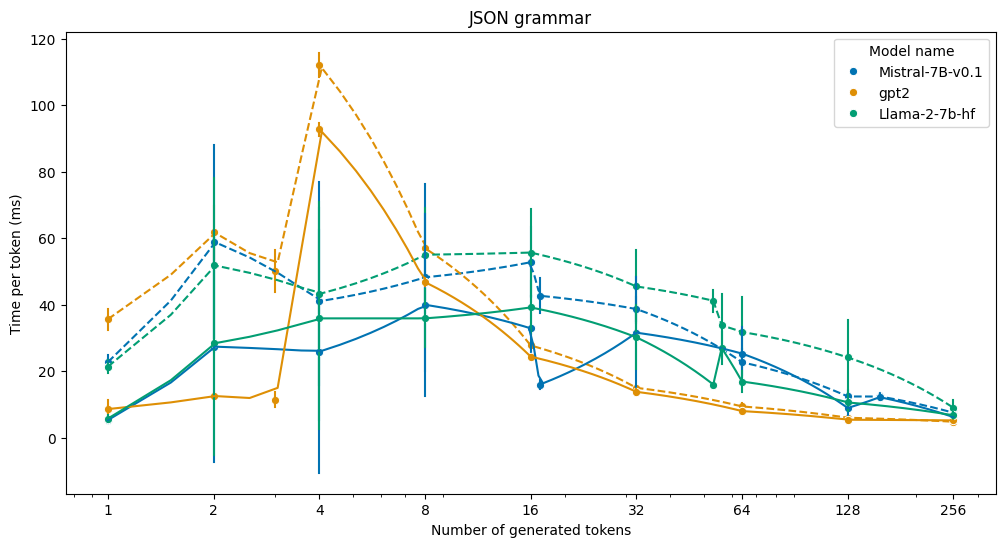

In [10]:
fix, ax = plt.subplots(1, 1, figsize=(12, 6));

groupby_column = 'model_name'

plot_benchmarking_results(profiling_before_dfs, ax, groupby_column, smoothing=False, line_plotting_kwrgs={'linestyle': '--'})
plot_benchmarking_results(profiling_after_dfs, ax, groupby_column, smoothing=False, line_plotting_kwrgs={'linestyle': '-', 'label':None})
ax.legend(title=" ".join(groupby_column.split("_")).capitalize(), labels=profiling_before_dfs[groupby_column].unique())

ax.set_xticks([2**i for i in range(9)])
ax.set_xticklabels([2**i for i in range(9)])
ax.set_title('JSON grammar')

In [229]:
def process_measurment_time(raw_dataframe):
    raw_dataframe['model_name'] = raw_dataframe['model_id'].str.split('/').str[-1]
    result = raw_dataframe.groupby(['n_tokens', 'model_name']).agg({'time_per_token': ['mean', 'std'], 'device': 'first'})
    result.columns = ['mean_time_per_token', 'std_time_per_token', 'device']
    return result
    